# Demo notebook BrightEyes_ISM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn
from numpy.random import poisson

import brighteyes_ism.analysis.APR_lib as apr
import brighteyes_ism.analysis.Deconv_lib as deconv
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.analysis.FocusISM_lib as fism
import brighteyes_ism.analysis.Tools_lib as tools
import brighteyes_ism.analysis.Graph_lib as gr

import brighteyes_ism.simulation.PSF_sim as ism
import brighteyes_ism.simulation.Tubulin_sim as simTub

## Point-spread functions

### Simulation settings and SPAD array parameters

In [2]:
grid = ism.GridParameters()

grid.N = 5 # number of detector elements in each dimension
grid.Nx = 201 # number of pixels of the simulation space
grid.pxsizex = 25 # pixel size of the simulation space (nm)
grid.pxdim = 50e3 # detector element size in real space (nm)
grid.pxpitch = 75e3 # detector element pitch in real space (nm)
grid.M = 500 # total magnification of the optical system (e.g. 100x objective follewd by 5x telescope)

#%% PSF simulation 2D

exPar = ism.simSettings()
exPar.wl = 640 # excitation wavelength (nm)
exPar.mask_sampl = 31

emPar = exPar.copy()
emPar.wl = 660 # emission wavelength (nm)

z_shift = 0 #nm

In [3]:
print('Detector width =', '%.2f' % grid.spad_size(), 'nm')

print('Airy Unit =', '%.2f' % emPar.airy_unit, 'nm')

print('Depth of Field =', '%.2f' % emPar.depth_of_field, 'nm')


Detector width = 700.00 nm
Airy Unit = 575.14 nm
Depth of Field = 1010.20 nm


### Generate excitation PSF and detection PSFs

In [4]:
PSF, detPSF, exPSF = ism.SPAD_PSF_2D(grid, exPar, emPar, z_shift=z_shift)

Calculating field near the focus:


XY plane: 100%|██████████| 201/201 [00:05<00:00, 33.56it/s]


Calculating field near the focus:


XY plane: 100%|██████████| 201/201 [00:05<00:00, 33.92it/s]


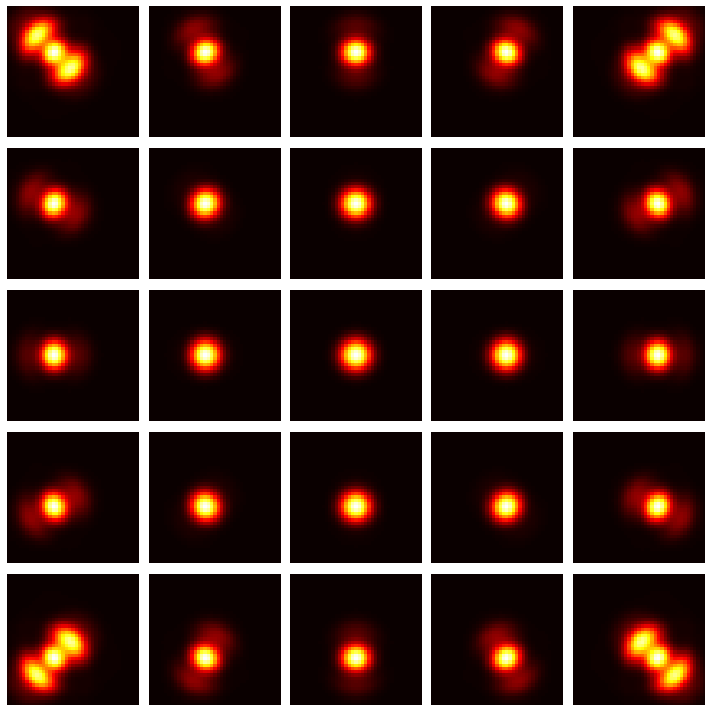

In [5]:
extent = [-(grid.Nx//2*grid.pxsizex), grid.Nx//2*grid.pxsizex, -(grid.Nx//2*grid.pxsizex), grid.Nx//2*grid.pxsizex]
xlims = (-500, 500)
ylims = (-500, 500)

fig = gr.ShowDataset(PSF, xlims = xlims, ylims = ylims, extent = extent, figsize = (10,10) )

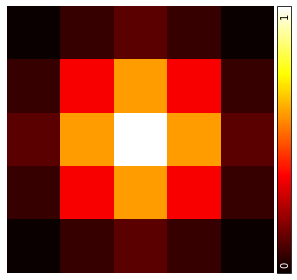

In [6]:
fingerprint = tools.fingerprint(PSF)

fig, ax = gr.ShowFingerprint(PSF, colorbar = True, normalize = True)

### Find shift vectors

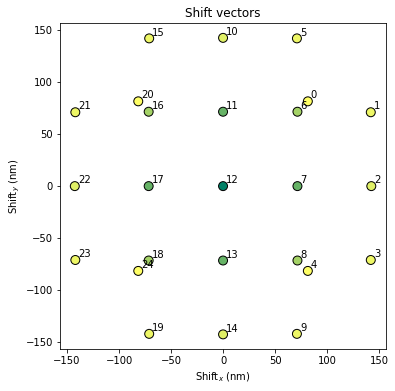

In [7]:
shift = apr.ShiftVectors(PSF, 100, 12)[0]
shift *= grid.pxsizex

fig, ax = plt.subplots(figsize = (6,6))

fig, ax = gr.PlotShiftVectors(shift, color = fingerprint, fig = fig, ax = ax)

## Tubulin

### Simulate ground truth

 50%|█████     | 3/6 [00:00<00:00, 12.76it/s]

tubulin filament out of the boundaries [50.84450373] [-0.01132073] 201
tubulin filament out of the boundaries [156.62713767] [-0.04857145] 201
tubulin filament out of the boundaries [-0.22649368] [129.66851984] 201


100%|██████████| 6/6 [00:00<00:00, 11.12it/s]

tubulin filament out of the boundaries [13.67628929] [201.13753732] 201


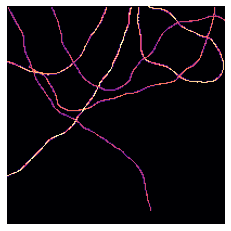

In [8]:
tubulin = simTub.tubSettings()
tubulin.xy_pixel_size = grid.pxsizex
tubulin.xy_dimension = grid.Nx
tubulin.xz_dimension = 1     
tubulin.z_pixel = 1     
tubulin.n_filament = 6
tubulin.radius_filament = grid.pxsizex*0.6
tubulin.intensity_filament = [0.5,0.9]  
phTub = simTub.functionPhTub(tubulin)
plt.figure()
plt.imshow(phTub[:,:,0],cmap='magma')
plt.axis('off')

TubDec = phTub[:,:,0]

### Simulate detected images

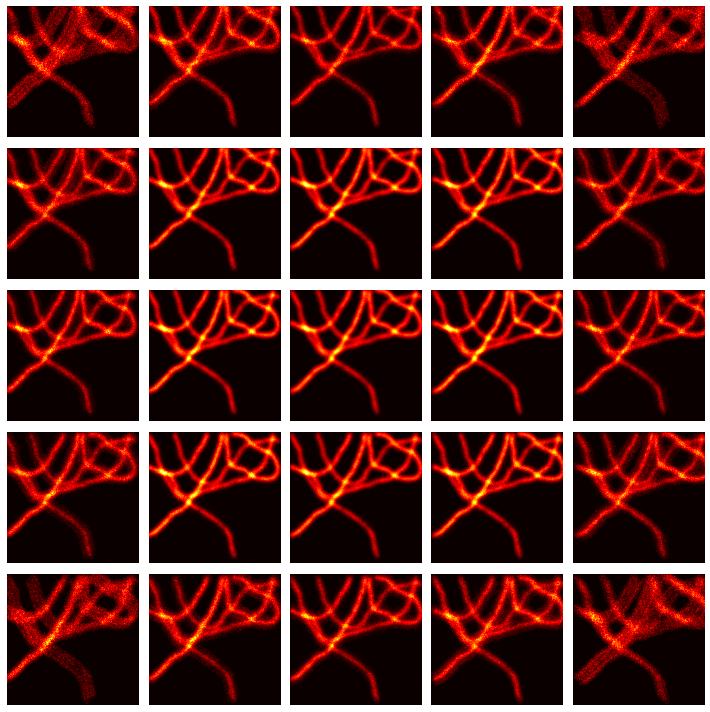

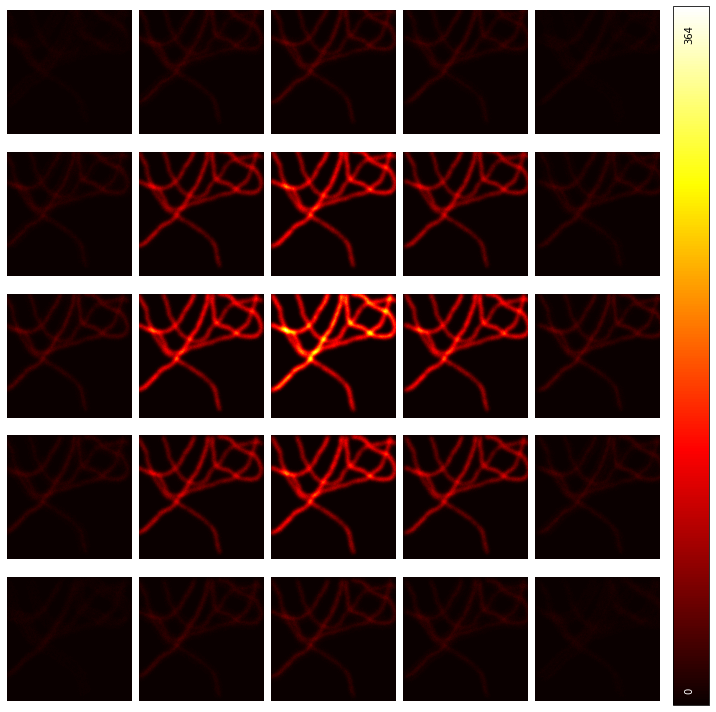

In [9]:
#%% Convolve tubulin with psf

img = np.empty(PSF.shape)

flux = 1e4
obj = TubDec*flux

for n in range(grid.N**2):
    img[:, :, n] = sgn.convolve(obj, PSF[:, :, n] ,mode = 'same')

#%% Convert to photons and add Poisson noise

img = np.uint16(img)

img_1 = poisson(img)
img_2 = poisson(img)

fig = gr.ShowDataset(img_1, figsize = (10,10), normalize = False )

fig_norm = gr.ShowDataset(img_1, figsize = (10,10), colorbar = True, normalize = True)

### Compare confocal and ISM

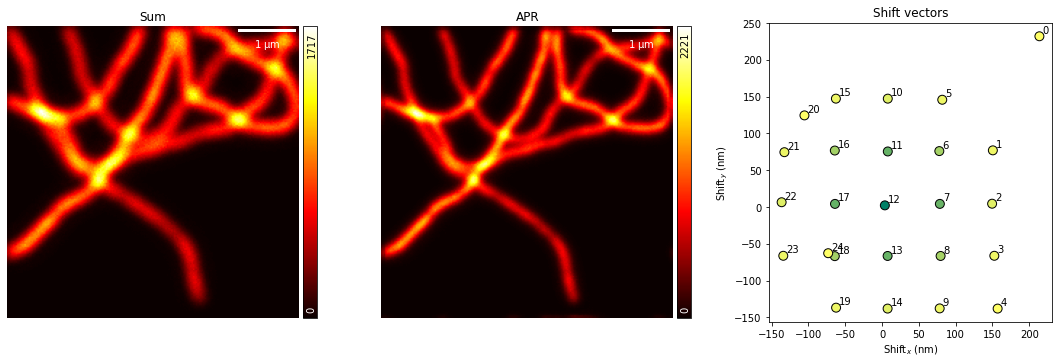

In [10]:
img_sum_1 = np.sum(img_1, axis = -1)
img_sum_2 = np.sum(img_2, axis = -1)

fingerprint_1 = tools.fingerprint(img_1)

usf = 100
ref = grid.N**2//2

shift_1, img_ism_1 = apr.APR(img_1, usf, ref, pxsize = grid.pxsizex)
shift_2, img_ism_2 = apr.APR(img_2, usf, ref, pxsize = grid.pxsizex)

img_ism_sum_1 = np.sum(img_ism_1, axis=-1)
img_ism_sum_2 = np.sum(img_ism_2, axis=-1)

px = grid.pxsizex * 1e-3

fig, ax = plt.subplots(1, 3, figsize=(15,5))

gr.ShowImg(img_sum_1, pxsize_x = px, fig = fig, ax = ax[0])
ax[0].set_title('Sum')

gr.ShowImg(img_ism_sum_1, pxsize_x = px, fig = fig, ax = ax[1])
ax[1].set_title('APR')

gr.PlotShiftVectors(shift_1, color = fingerprint_1, fig = fig, ax = ax[2])

fig.tight_layout()

### Multi-image deconvolution

Multi-image deconvolution:


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


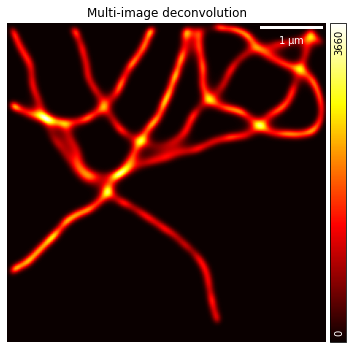

In [11]:
img_deconv = deconv.MultiImg_RL_FFT( PSF, img_1, max_iter = 10)

fig, ax = plt.subplots(figsize=(5,5))

gr.ShowImg(img_deconv, pxsize_x = px, fig = fig, ax = ax)
ax.set_title('Multi-image deconvolution')

fig.tight_layout()

### Calculate resolution based on FRC analysis

Text(0.5, 1.0, 'ISM - Resolution = 150.82 nm')

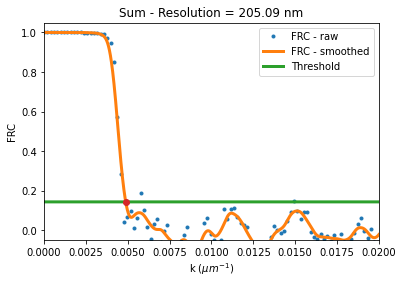

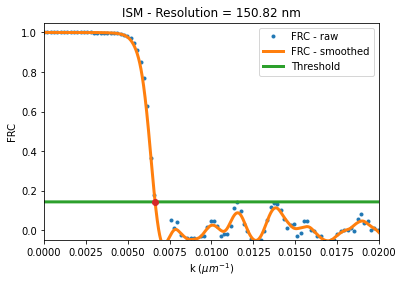

In [12]:
frc_sum = frc.FRC_resolution(img_sum_1, img_sum_2, px=grid.pxsizex)

frc_ism = frc.FRC_resolution(img_ism_sum_1, img_ism_sum_2, px=grid.pxsizex)

frc.plotFRC(*frc_sum)
plt.title(f'Sum - Resolution = {frc_sum[0]:.2f} nm')

frc.plotFRC(*frc_ism)
plt.title(f'ISM - Resolution = {frc_ism[0]:.2f} nm')

### Generate out-of-focus PSFs

Calculating field near the focus:


XY plane: 100%|██████████| 201/201 [00:06<00:00, 33.24it/s]


Calculating field near the focus:


XY plane: 100%|██████████| 201/201 [00:06<00:00, 33.15it/s]


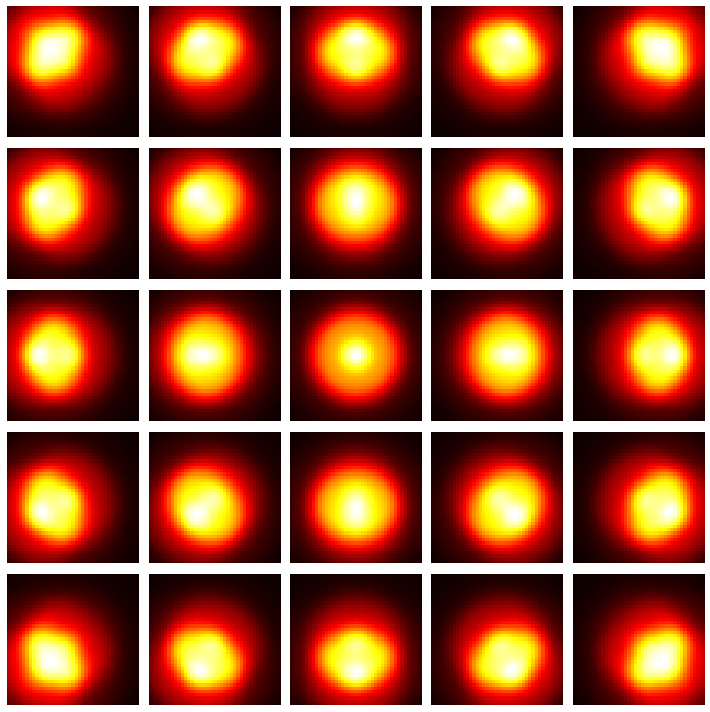

In [13]:
PSF_oof, detPSF_oof, exPSF_oof = ism.SPAD_PSF_2D(grid, exPar, emPar, z_shift = emPar.depth_of_field/2)

fig = gr.ShowDataset(PSF_oof, xlims = xlims, ylims = ylims, extent = extent, figsize = (10,10) )

### Calculate photons from out-of-focus tubulin

 33%|███▎      | 2/6 [00:00<00:00, 19.09it/s]

tubulin filament out of the boundaries [73.02805056] [-0.03156746] 201
tubulin filament out of the boundaries [138.25086017] [-0.42111074] 201


100%|██████████| 6/6 [00:00<00:00, 11.90it/s]

tubulin filament out of the boundaries [159.55511053] [201.07324097] 201
tubulin filament out of the boundaries [201.00881246] [157.93729562] 201
tubulin filament out of the boundaries [201.47714334] [55.84721688] 201


100%|██████████| 6/6 [00:00<00:00, 12.59it/s]


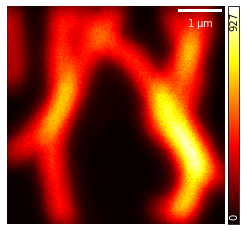

In [14]:
#%% Generate tubulin

tubulin = simTub.tubSettings()
tubulin.xy_pixel_size = grid.pxsizex
tubulin.xy_dimension = grid.Nx
tubulin.xz_dimension = 1     
tubulin.z_pixel = 1     
tubulin.n_filament = 6
tubulin.radius_filament = grid.pxsizex*0.6
tubulin.intensity_filament = [0.5,0.9]  
phTub = simTub.functionPhTub(tubulin)

TubDec = phTub[:,:,0]
flux = 1e4
obj_oof = TubDec*flux

#%% Convolve tubulin with psf

img_oof = np.empty(PSF.shape)

for n in range(grid.N**2):
    img_oof[:, :, n] = sgn.convolve(obj_oof, PSF_oof[:, :, n] ,mode = 'same')

#%% Convert to photons and add Poisson noise

img_oof = np.uint16(img_oof)

img_oof = poisson(img_oof)

# show it

img_oof_sum = np.sum(img_oof, axis = -1)

fig, ax = gr.ShowImg(img_oof_sum, pxsize_x = px)

### Sum in-focus and out-of-focus light

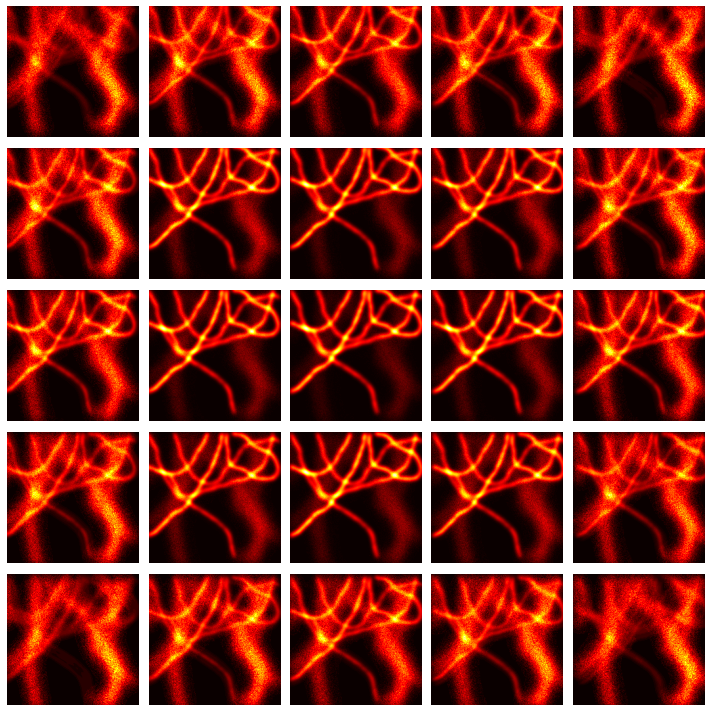

In [15]:
#%% Add oof tubulin

img_bkg = img + img_oof
img_bkg_sum = img_bkg.sum(axis=-1)
#%% Show total dataset

fig = gr.ShowDataset(img_bkg, figsize = (10,10) )

### Apply focus-ISM

In [16]:
img_bkg_sum = np.sum(img_bkg, axis = -1)

Focus_sum, Bkg_sum, ism_sum = fism.focusISM(img_bkg, calibration = PSF)

Focus-ISM - parallel:


100%|██████████| 40401/40401 [03:38<00:00, 184.76it/s]


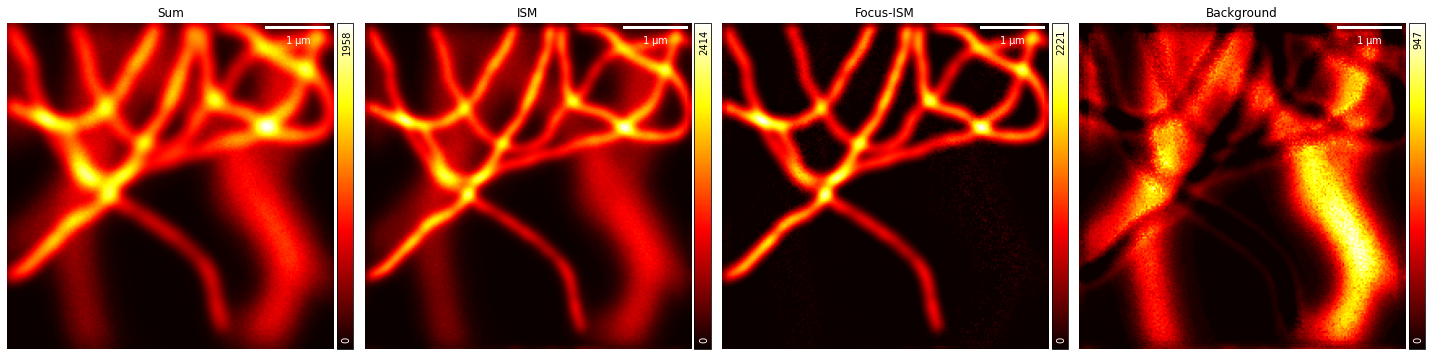

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20,10))

gr.ShowImg(img_bkg_sum, pxsize_x = px, fig = fig, ax = ax[0])
ax[0].set_title('Sum')


gr.ShowImg(ism_sum, pxsize_x = px, fig = fig, ax = ax[1])
ax[1].set_title('ISM')


gr.ShowImg(Focus_sum, pxsize_x = px, fig = fig, ax = ax[2])
ax[2].set_title('Focus-ISM')


gr.ShowImg(Bkg_sum, pxsize_x = px, fig = fig, ax = ax[3])
ax[3].set_title('Background')


fig.tight_layout()